In [1]:
from sciSOM import *

In [2]:
import pandas as pd
import numpy as np
import random

In [3]:
# Import the pengiuns dataset, 
# normalize the data approriately, 
# finally put it through the SOM

In [4]:
# Lets make a simple dataset which we understand
# I will generate 4 data classes centered at 1,1 1,2 2,1 2,2
# Add some gaussian noise to each of those classes and see
# If the SOM was able to separate them!
n_samples = 2000  # Total number of samples
centers = np.array([[1, 1], [1, 2], [2, 1], [2, 2]])  # Centers of the 4 Gaussian distributions
std_dev = 0.1  # Standard deviation of the Gaussian distributions
n_centers = len(centers)
samples_per_center = n_samples // n_centers

In [5]:
data = []
for center in centers:
    samples = np.random.normal(loc=center, scale=std_dev, size=(samples_per_center, 2))
    data.append(samples)

# Combine all samples into a single array
gaussian_data_4_classes = np.vstack(data)

Text(0, 0.5, 'Y')

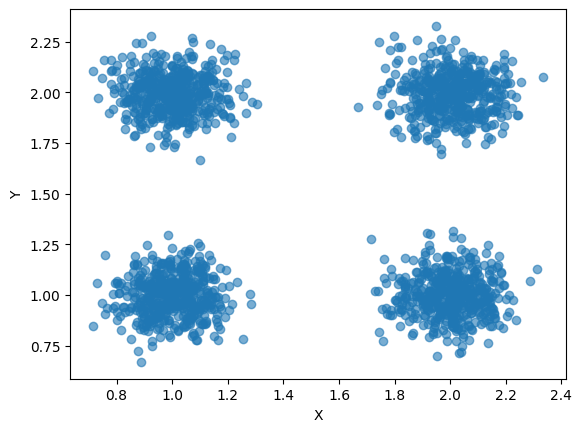

In [6]:
plt.scatter(gaussian_data_4_classes[:, 0], gaussian_data_4_classes[:, 1], alpha=0.6)
plt.xlabel('X')
plt.ylabel('Y')
#plt.title('Generated Gaussian Mixture Dataset')
#plt.show()

In [7]:
penguins_df = pd.read_csv("../test_data/penguins.csv")

In [8]:
adelie_df = penguins_df[penguins_df["species"] == "Adelie"].dropna()
gentoo_df = penguins_df[penguins_df["species"] == "Gentoo"].dropna()
chinstrap_df = penguins_df[penguins_df["species"] == "Chinstrap"].dropna()

In [9]:
len(adelie_df)

146

In [10]:
len(gentoo_df)

119

In [11]:
species = np.concatenate([np.zeros(len(adelie_df)), 
                          np.ones(len(gentoo_df)), 
                          2*np.ones(len(chinstrap_df))])


In [12]:
len(species)

333

In [13]:
# Now normalize the data and give the input to the SOM
penguins_df = penguins_df.dropna()

In [14]:
penguins_df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [15]:
def convert_to_float(arr):
    # Flatten the array to handle nested objects if any
    flat_arr = arr.ravel()
    
    # Convert all elements to float
    flat_arr = [float(element) for element in flat_arr]
    
    # Reshape back to the original shape
    return np.array(flat_arr).reshape(arr.shape)

In [16]:
penguins_df.to_numpy()

array([['Adelie', 'Torgersen', 39.1, ..., 3750.0, 'male', 2007],
       ['Adelie', 'Torgersen', 39.5, ..., 3800.0, 'female', 2007],
       ['Adelie', 'Torgersen', 40.3, ..., 3250.0, 'female', 2007],
       ...,
       ['Chinstrap', 'Dream', 49.6, ..., 3775.0, 'male', 2009],
       ['Chinstrap', 'Dream', 50.8, ..., 4100.0, 'male', 2009],
       ['Chinstrap', 'Dream', 50.2, ..., 3775.0, 'female', 2009]],
      dtype=object)

In [17]:
input_data= np.array((penguins_df.to_numpy()[:,2],
                    penguins_df.to_numpy()[:,3],
                    penguins_df.to_numpy()[:,4],
                    penguins_df.to_numpy()[:,5]))

In [18]:
input_data = convert_to_float(input_data)

In [19]:
input_data = np.transpose(input_data)

In [20]:
input_data.dtype

dtype('float64')

In [21]:
gaussian_data_4_classes_norm = affine_transform(gaussian_data_4_classes, 0, 1)
data_normalized = affine_transform(input_data, 0, 1)

In [22]:
np.max(data_normalized)

1.0

In [23]:
# Make the input parameter table
dtype = np.dtype([
    ('time', 'i8'),  # Unicode string of max length 10
    ('alpha', 'float'),    # 4-byte integer
    ('sigma', 'float'),  # 4-byte float
    ('max_radius', 'i8')
])

In [24]:
parameters = np.zeros(1, dtype=dtype)

In [28]:
parameters[0] = (100, 0.3, 0.2, 3)

In [29]:
parameters_g = np.zeros(1, dtype=dtype)
parameters_g[0] = (0, 0.1, 0.2, 2)

In [30]:
parameters_schedule = np.zeros(3, dtype=dtype)
parameters_schedule[0] = (2000, 0.3, 0.2, 3)
parameters_schedule[1] = (8000, 0.07, 0.1, 2)
parameters_schedule[2] = (20000, 0.07, 0.1, 2)

In [31]:
np.sum(parameters_schedule['time'] <= 3000)

1

In [32]:
som_model_simple = SOM(x_dim = 5, y_dim = 5, input_dim = 2, n_iter=20000,
                   learning_parameters=parameters_schedule,
                   decay_type='schedule', mode = "batch", #neighborhood_decay = "exponential"
                   )

In [33]:
# There seems to be some sort of issue, when given a dataset of 1000 points 
# distributed around 4 points we get correct results yet with one cluster getting
# Preferential treatmnet (more space). This tends to be whatever is mapped to
# The lower right sections, maybe the parameters are just not good?

# Will try to test out the scheduled decay next and see if that helps

In [46]:
div_zero_test = np.array(([[0.0, 0.0], [0.0,0.0]]))

NameError: name 'array' is not defined

In [42]:
affine_transform(div_zero_test, 0, 1)

UnboundLocalError: cannot access local variable 'normalized_data' where it is not associated with a value

In [45]:
any(np.min(div_zero_test, axis = 0)-np.max(div_zero_test, axis = 0) == 0)

True

In [40]:
som_model_simple.is_trained

True

In [34]:
np.shape(gaussian_data_4_classes_norm)

(2000, 2)

Text(0, 0.5, 'Y')

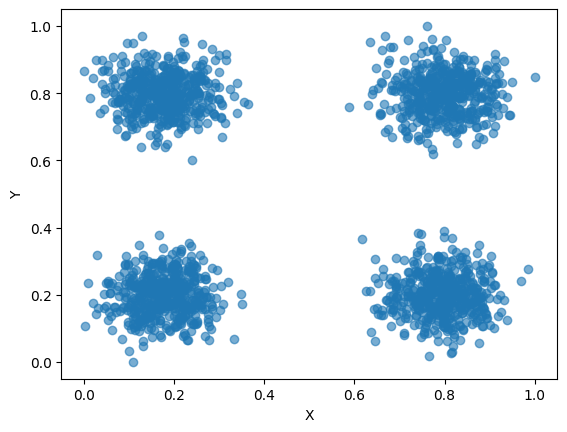

In [35]:
plt.scatter(gaussian_data_4_classes_norm[:, 0], gaussian_data_4_classes_norm[:, 1], alpha=0.6)
plt.xlabel('X')
plt.ylabel('Y')

In [36]:
gaussian_data_4_classes_norm.dtype

dtype('float64')

In [37]:
len(gaussian_data_4_classes_norm)

2000

In [38]:
som_model_simple.train(gaussian_data_4_classes_norm)

In [39]:
gaussian_data_4_classes_wcube = som_model_simple.weight_cube

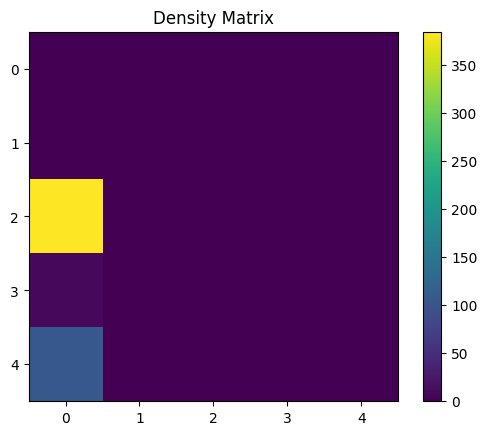

In [176]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[:500])
display_density_matrix(DENS_MAT)

In [184]:
import pytest

ModuleNotFoundError: No module named 'pytest'

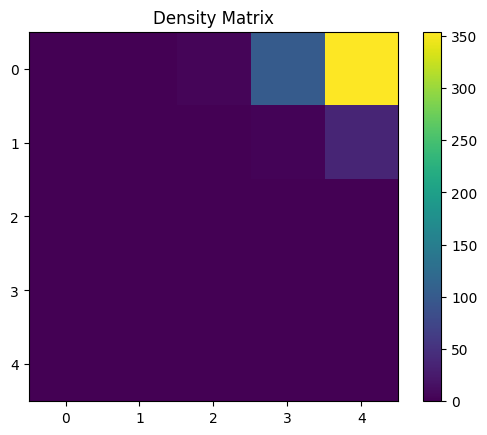

In [177]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[500:1000])
display_density_matrix(DENS_MAT)

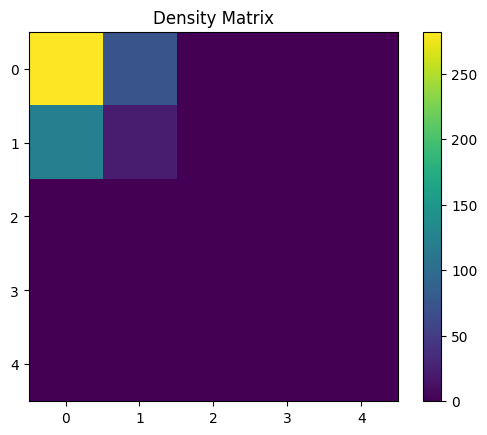

In [178]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[1000:1500])
display_density_matrix(DENS_MAT)

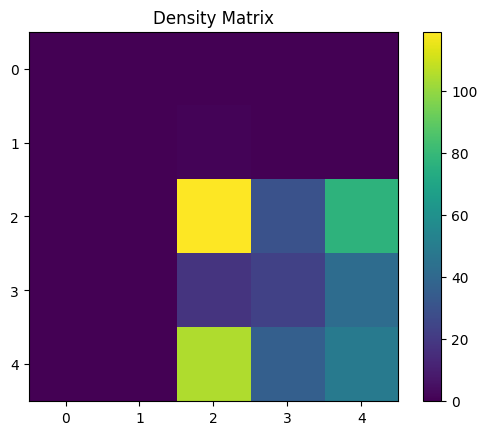

In [179]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[1500:])
display_density_matrix(DENS_MAT)

In [113]:
n_iter = 10000

In [62]:
 math.ceil(n_iter/ len(gaussian_data_4_classes_norm))

10

In [63]:
n_iter % len(gaussian_data_4_classes_norm) 

0

In [ ]:
batches = math.ceil(self.n_iter/ len(data))
        reminder = self.n_iter % len(data) 
        indecies = np.zeros(self.n_iter)

        for batch in range(batches):
            if batch != batches - 1:
                indecies[batch*len(data): (1 + batch)*len(data)] = random.sample(list(np.arange(len(data))), len(data))
            else:
                indecies[(batch)*len(data):] = random.sample(list(np.arange(len(data))), reminder)

In [30]:
som_model = SOM(x_dim = 5, y_dim = 5, input_dim = 4, n_iter=5000,
               learning_parameters=parameters,
               decay_type='exponential',
               )

In [31]:
som_model.train(data_normalized)

In [32]:
wcube = som_model.weight_cube

In [33]:
som_model.learning_rate_hist()

array([0.3       , 0.29982005, 0.29964022, ..., 0.01496303, 0.01495405,
       0.01494508])

Text(0, 0.5, 'Learning rate [aplha]')

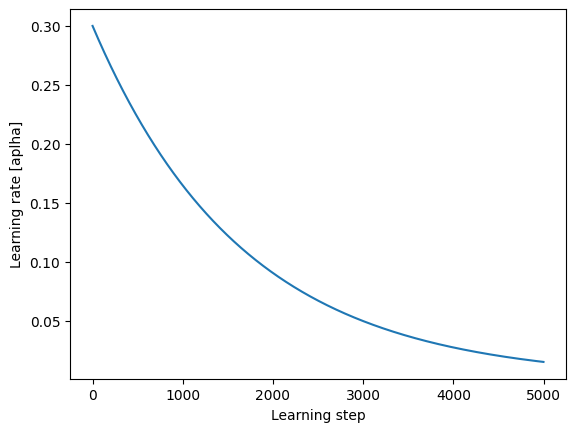

In [40]:
plt.plot(som_model.learning_rate_history)
plt.xlabel("Learning step")
plt.ylabel("Learning rate [aplha]")

Text(0, 0.5, 'Neighborhood Radius')

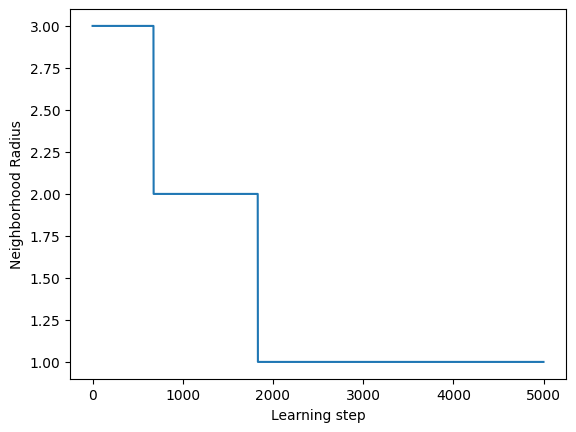

In [41]:
plt.plot(som_model.learning_radius_history)
plt.xlabel("Learning step")
plt.ylabel("Neighborhood Radius")

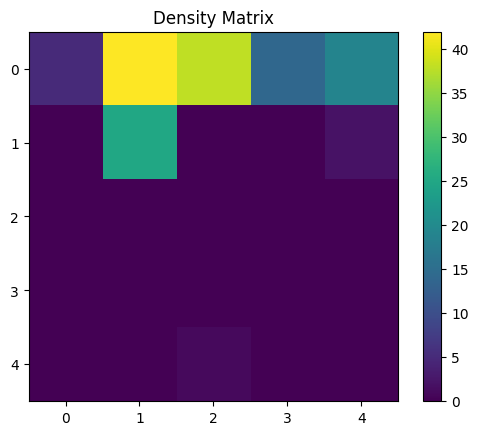

In [36]:
# Now lets test if we are getting resonable results.
#peaklet_decile = data_to_log_decile_log_area_aft_recall(peaklets_expaneded[3068176:], norm_factors)
U_MAT = calculate_u_matrix(wcube)
DENS_MAT = calculate_density_matrix(wcube, U_MAT, data_normalized[:146])
display_density_matrix(DENS_MAT)

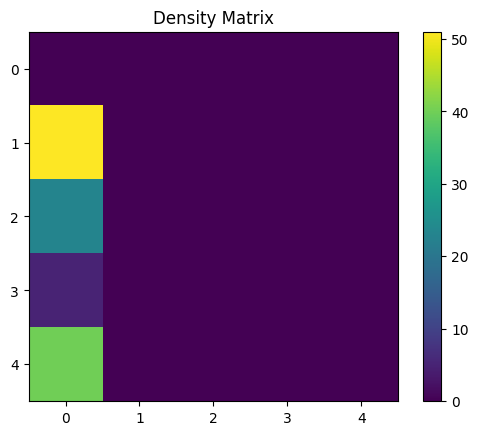

In [37]:
U_MAT = calculate_u_matrix(wcube)
DENS_MAT = calculate_density_matrix(wcube, U_MAT, data_normalized[146:146+119])
display_density_matrix(DENS_MAT)

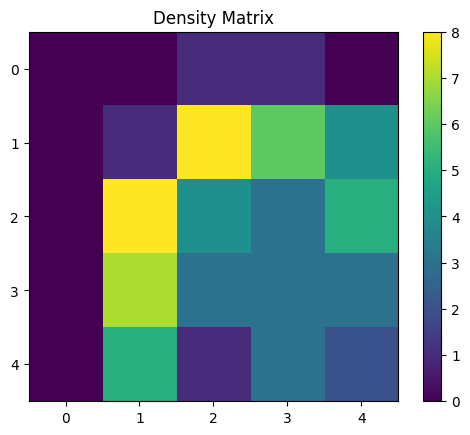

In [38]:
U_MAT = calculate_u_matrix(wcube)
DENS_MAT = calculate_density_matrix(wcube, U_MAT, data_normalized[146+119:])
display_density_matrix(DENS_MAT)

In [32]:
1 / 2 ** 2

0.25

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from typing import Union

def SOM_gird_avg_wavefrom_per_cell(input_data: np.ndarray, 
                                   nunr_file_input: str, 
                                   grid_x_dim: int, 
                                   grid_y_dim: int, 
                                   x_dim_data_cube: int, 
                                   output_img_name: str, 
                                   is_struct_array = True):
    """
    Generates image of the average waveform for each cell in the SOM grid.

    This function take in a nunr file from NeuroScope and converts it into a useful format to us
    Then it uses the data in the nunr file to identify which data samples belong to each PE
    Finally it takes this data and plots it such that we can overlay any data we want.

    Parameters
    ----------
    input_data : int
        waveforms (peaks, peaklets)
    nunr_file_input : str 
        text file output from neuroscope
    grid_x_dim : int   
        SOM x-dimension
    grid_y_dim: int  
        SOM y-dimension
    x_dim_data_cube : int 
        x-dimension of the input data cube for the SOM
    output_img_name : str      
        name of file to save the image to + path
    is_struct_array : bool 
        does the data need to be accessed as peaks['data']?
    """
    
    # Import nunr file and convert it into a useful format
    import io
    nunr_file = []
    with io.open(nunr_file_input, mode="r", encoding="utf-8") as f:
        next(f)
        #next(f)
        for line in f:
            nunr_file.append(line.split())
    
    PE_data = nunr_to_obj(nunr_file, x_dim_data_cube)
    
    # Plotting section
    xgrid = grid_x_dim
    ygrid = grid_y_dim
    fig, ax = plt.subplots(nrows=ygrid, ncols=xgrid, figsize=(20, 20))

    a = 1
    for i in np.arange(ygrid):
        for j in np.arange(xgrid):
            if PE_data[(i+1) + (j)*xgrid] != []:
                [_, data_dim] = np.shape(input_data)
                data = input_data[np.array(PE_data[(i+1) + (j)*xgrid])-1]
                if is_struct_array == True:
                    ax[39-j,i].plot(np.mean(data['data'], axis = 0), alpha = a, color = 'black')
                elif is_struct_array == False:
                    ax[39-j,i].plot(np.mean(data, axis = 0), alpha = a, color = 'black')
            if PE_data[(i+1) + (j)*xgrid] == []:
                if is_struct_array == True:
                    ax[39-j,i].plot(np.zeros(200), alpha = a, color = 'black')
                else:
                    ax[39-j,i].plot(np.zeros(data_dim), alpha = a, color = 'black')
            #kind = kind + 1
            #ax[i,j].set_xlabel('Sample #')
            if is_struct_array == True:
                ax[i,j].set_xlim(0, 200)
            else:
                ax[i,j].set_xlim(0, data_dim)
            ax[i,j].axis('off')

    fig.savefig(output_img_name, bbox_inches='tight')
    
def calculate_u_matrix(weight_cube: np.ndarray):
    """
    Calculate the distance (fences) for each adjacent neuron in an SOM.

    (Need to review this function, dont fully remember what is going on in the
    implementation)

    Parameters
    ----------
    weight_cube : np.ndarray
        The weight cube for the SOM

    Returns
    -------
    u_matrix : np.ndarray
        The distance matrix for neurons in the SOM
    """
    x, y, _ = weight_cube.shape
    u_matrix = np.zeros((x, y))

    for i in range(x):
        for j in range(y):
            neighbors = []
            if i > 0:
                neighbors.append(weight_cube[i-1, j])
            if i < x-1:
                neighbors.append(weight_cube[i+1, j])
            if j > 0:
                neighbors.append(weight_cube[i, j-1])
            if j < y-1:
                neighbors.append(weight_cube[i, j+1])

            distances = [np.linalg.norm(weight_cube[i, j] - neighbor) for neighbor in neighbors]
            u_matrix[i, j] = np.mean(distances)

    return u_matrix

def calculate_density_matrix(weight_cube: np.ndarray, 
                             u_matrix: np.ndarray, 
                             dataset: np.ndarray) -> np.ndarray:
    """
    Calculate density matrix for a given som weight cube and dataset.

    **This function is not working as intended, need to review it**
    It is not acutally using the information of the u_matrix

    Parameters
    ----------

    weight_cube : np.ndarray
        SOM weight cube
    u_matrix : np.ndarray
        output from calculate_u_matrix
    dataset:    
        Data in the same form given to the SOM as input for training

    Returns
    -------
    density_matrix : np.ndarray
        The density matrix for the given dataset
    """
    x, y = u_matrix.shape
    density_matrix = np.zeros((x, y))

    for data_point in dataset:
        distances = cdist(weight_cube.reshape(-1, weight_cube.shape[-1]), [data_point], metric='euclidean')
        #print(np.shape(weight_cube.reshape(-1, weight_cube.shape[-1])))
        #print(np.shape(data_point))
        bmus = np.argmin(distances)
        x_idx, y_idx = np.unravel_index(bmus, (x, y))
        density_matrix[x_idx, y_idx] += 1

    return density_matrix

def display_density_matrix(density_matrix: np.ndarray):
    """
    Display the density matrix as an image.

    Parameters
    ----------
    density_matrix : np.ndarray
        The density matrix to display
    """
    import matplotlib.pyplot as plt
    plt.imshow(density_matrix, cmap='viridis')
    plt.colorbar()
    plt.title('Density Matrix')
    plt.show()
    
def rise_time_vs_area_SOM_clusters(data: np.ndarray, colors: Union[list, np.ndarray], 
                                   n_rows: int, n_cols: int):
    """
    Plots the rise time vs area for each cluster in the SOM.

    Takes in the data from peaklet level data using the SOM classification
    and outputs a grid of plots showing each cluster.

    Parameters
    ----------
    
    data : np.ndarray     
        strudtured array with XENONnT data of data type peaks or peaklet
    colors : list or np.ndarray   
        list of colors used by the SOM
    n_rows:   
        number of coulmns in grid with the plots 
    n_cols:   
        number of rows in grid with the plots 
    """
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(24, 18))

    # Generalize this later
    colors = np.vstack((colors, np.array([0,0,0]).reshape((1, 3))))
    num = 0
    for i in np.arange(n_rows):
        for j in np.arange(n_cols):
            ax[i,j].scatter(data['area'][data['type'] == num],
                            -data['area_decile_from_midpoint'][data['type'] == num][:,1], 
                            s=0.5, color = colors[num]/255, alpha = 1)
            ax[i,j].set_xscale('log')
            ax[i,j].set_yscale('log')
            ax[i,j].set_xlim(1,10000000)
            ax[i,j].set_ylim(10,100000)
            num = num + 1


def nunr_file_to_list(nunr_file: list):
    """
    Extracts the PE data from a nunr file and converts it into a list.

    Parameters
    ----------
    nunr_file : list
        Opened nunr file from NeuroScope, needs to be parced to extract the PE data
    """
    obj = {}
    for i in range(1, len(nunr_file) + 1):
        obj[i] = []

    for i in np.arange(len(nunr_file)):  # also length of obj
        skip = 3  # every 3rd value is a char we dont care about
        for j in np.arange(int(len(nunr_file[i][2:]) / 3)):
            if (skip % 3) == 0:
                if tuple(nunr_file[i][skip:skip + 2]) != ('152', '991'):
                    obj[i + 1].append(tuple(nunr_file[i][skip:skip + 2]))
                    skip = skip + 3

    return obj


def tuple_list_to_list(tuple_list, x_data_img):
    obj = {}
    for i in range(1, len(tuple_list) + 1):
        obj[i] = []

    for i in np.arange(len(tuple_list)):
        for j in np.arange(len(tuple_list[i + 1])):
            obj[i + 1].append(int(tuple_list[i + 1][j][0]) + ((int(tuple_list[i + 1][j][1]) - 1) * x_data_img))

    return obj

def nunr_to_obj(nunr_file, x_data_img):
    return tuple_list_to_list(nunr_file_to_list(nunr_file), x_data_img)


In [37]:
max((0, 1))

1

In [78]:
from scipy.spatial.distance import cdist


In [54]:
data_normalized[0]

array([0.2545454545454545, 0.6666666666666666, 0.15254237288135594,
       0.2916666666666667], dtype=object)

In [50]:
wcube.dtype

dtype('float64')

In [52]:
np.array(data_normalized).dtype

dtype('O')

In [82]:
cdist(wcube.reshape(-1, wcube.shape[-1]), 
      data_normalized[0].reshape(1,4), metric='euclidean')

array([[0.48403412],
       [0.89190349],
       [0.8195032 ],
       [1.04155527],
       [1.04457631],
       [0.06793528],
       [0.9494176 ],
       [0.74916846],
       [0.90012271],
       [0.23265822],
       [0.85929249],
       [1.06190398],
       [0.32965717],
       [0.72896125],
       [0.34731289],
       [0.80097655],
       [0.53696731],
       [1.02901284],
       [0.77192112],
       [0.68311399],
       [0.80987287],
       [0.64685325],
       [0.77845353],
       [1.0343982 ],
       [0.82436124]])

In [80]:
np.shape(cdist(wcube.reshape(-1, wcube.shape[-1]), 
      data_normalized, metric='euclidean'))

(25, 333)

In [49]:
wcube.reshape(-1, wcube.shape[-1])

array([[0.21287869, 0.50879025, 0.44152237, 0.66878785],
       [0.95856674, 0.21057939, 0.84362449, 0.18624263],
       [0.77097951, 0.62875633, 0.32523233, 0.26318844],
       [0.07712841, 0.29732328, 0.26012827, 0.22816716],
       [0.98219083, 0.0950885 , 0.25433704, 0.59502817],
       [0.89491946, 0.22144856, 0.23693851, 0.34694968],
       [0.55164586, 0.94520846, 0.38034839, 0.63258965],
       [0.12903751, 0.46247634, 0.15086847, 0.00314737],
       [0.98440292, 0.65204037, 0.49790433, 0.95024703],
       [0.49721284, 0.73642722, 0.48190312, 0.12755617],
       [0.38791867, 0.90381826, 0.27855179, 0.26881773],
       [0.79553883, 0.59396897, 0.40718488, 0.08191962],
       [0.06191281, 0.73955327, 0.78238954, 0.91298884],
       [0.06361037, 0.58472594, 0.40355839, 0.33300909],
       [0.82282626, 0.27746643, 0.57168684, 0.12455659],
       [0.37271354, 0.31810403, 0.23192673, 0.95438281],
       [0.25355395, 0.51442473, 0.5427851 , 0.34947427],
       [0.28453191, 0.19071742,

In [48]:
data_normalized[0]

array([0.2545454545454545, 0.6666666666666666, 0.15254237288135594,
       0.2916666666666667], dtype=object)

In [44]:
np.shape(data_normalized[0,:].reshape(1,4))

(1, 4)

In [30]:
np.shape(wcube)

(5, 5, 4)

In [15]:
penguins_df['species']

0         Adelie
1         Adelie
2         Adelie
4         Adelie
5         Adelie
         ...    
339    Chinstrap
340    Chinstrap
341    Chinstrap
342    Chinstrap
343    Chinstrap
Name: species, Length: 333, dtype: object